# ATAC - S1D1
## Train Poisson and PeakVI embedding

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import poisson_atac as patac

Global seed set to 0
/home/icb/nina.sander/miniconda3/envs/atac/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/icb/nina.sander/miniconda3/envs/atac/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## Loading data

In [2]:
adata_all = sc.read('GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')

In [3]:
adata = adata_all[adata_all.obs.batch.isin(['s1d1'])]
#sc.pp.log1p(adata)
adata_atac = adata[:,adata.var_names[adata.var.feature_types.isin(['ATAC'])]]

In [11]:
adata.var_names

Index(['AL627309.5', 'LINC01409', 'LINC01128', 'NOC2L', 'KLHL17', 'ISG15',
       'C1orf159', 'SDF4', 'B3GALT6', 'UBE2J2',
       ...
       'GL000195.1-137376-138301', 'GL000219.1-39933-40839',
       'GL000219.1-42172-43054', 'GL000219.1-44703-45584',
       'GL000219.1-45726-46450', 'GL000219.1-90062-90937',
       'GL000219.1-99257-100160', 'KI270726.1-27152-28034',
       'KI270713.1-21434-22336', 'KI270713.1-29629-30491'],
      dtype='object', length=129921)

In [10]:
adata[:,adata.var_names[adata.var.feature_types.isin(['ATAC'])]].X

<6224x116490 sparse matrix of type '<class 'numpy.float32'>'
	with 20453045 stored elements in Compressed Sparse Row format>

we can use scanpy functions to handle, filter, and manipulate the data. In our case, we might want to filter out peaks that are rarely detected, to make the model train faster:

In [14]:
print(adata_atac.shape)
# compute the threshold: 5% of the cells
min_cells = int(adata_atac.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata_atac, min_cells=min_cells)
print(adata_atac.shape)

(6224, 116490)


/home/icb/nina.sander/miniconda3/envs/atac/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


(6224, 14488)


## PoissonVI model

In [15]:
patac.model.PoissonVI.setup_anndata(adata_atac, layer="counts") # if you have batches use batch='obs_key'

In [16]:
model = patac.model.PoissonVI(adata_atac)

In [17]:
model.train()#train_size=0.9, validation_size=0.1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/nina.sander/miniconda3/envs/atac/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 192/500:  38%|███▊      | 192/500 [01:53<03:01,  1.70it/s, loss=1.05e+04, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 10463.071. Signaling Trainer to stop.


In [18]:
#model.save("trained_model", overwrite=True)

## Visualisation and analysis of the latent space/ embedding

In [19]:
# Get latent embedding of cells
X_emb = model.get_latent_representation(adata_atac)
adata_atac.obsm['X_poissonVI'] = X_emb

print(X_emb.shape)

(6224, 10)


/home/icb/nina.sander/miniconda3/envs/atac/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


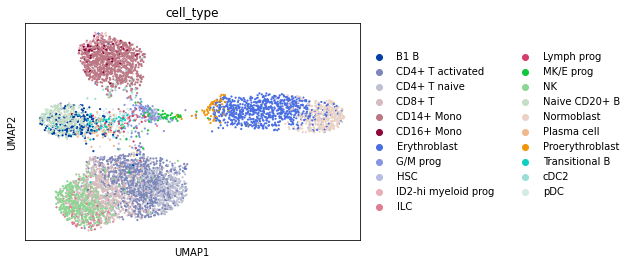

In [20]:
sc.pp.neighbors(adata_atac, use_rep='X_poissonVI')
sc.tl.umap(adata_atac)
#sc.tl.leiden(adata_atac, key_added = 'cluster_poissonvi')#, resolution=0.3)
sc.pl.umap(adata_atac, color=['cell_type'])#, 'cluster_poissonvi'])

# PeakVI

In [26]:
import scvi

In [23]:
# delete Nan Values
adata_atac.obsm['ATAC_lsi_red_new'] = adata_atac.obsm['ATAC_lsi_red'][:,0:-1]

In [24]:
print(adata_atac.shape)

(6224, 14488)


In [27]:
scvi.model.PEAKVI.setup_anndata(adata_atac, layer="counts")

In [28]:
pvi = scvi.model.PEAKVI(adata_atac)

In [29]:
pvi.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/nina.sander/miniconda3/envs/atac/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 118/500:  24%|██▎       | 118/500 [01:12<03:55,  1.63it/s, loss=8.44e+07, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 5464.490. Signaling Trainer to stop.


In [30]:
# Get latent embedding of cells
latent = pvi.get_latent_representation(adata_atac)
adata_atac.obsm['X_PeakVI'] = latent
print(latent.shape)

(6224, 10)


/home/icb/nina.sander/miniconda3/envs/atac/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


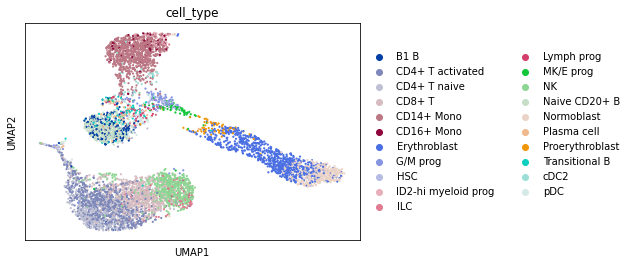

In [31]:
sc.pp.neighbors(adata_atac, use_rep="X_PeakVI")
sc.tl.umap(adata_atac)
sc.pl.umap(adata_atac, color=['cell_type'])

# save poissonvae as umap

/home/icb/nina.sander/miniconda3/envs/atac/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


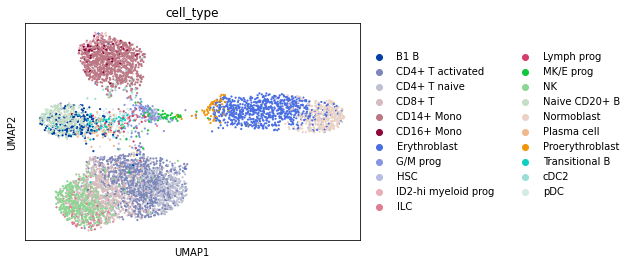

In [32]:
sc.pp.neighbors(adata_atac, use_rep='X_poissonVI')
sc.tl.umap(adata_atac)
sc.pl.umap(adata_atac, color=['cell_type'])#, 'cluster_poissonvi'])

## Save data as h5ad file

In [33]:
adata_atac

AnnData object with n_obs × n_vars = 6224 × 14488
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'n_cells'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_poissonVI', 'X_umap', 'ATAC_lsi_red_new', 'X_PeakVI'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [35]:
adata_atac.write('atac_vae.h5ad')

# Preprocess

In [36]:
from muon import atac as ac

In [57]:
atac = sc.read('atac_vae.h5ad')

In [58]:
atac.X.A

array([[0., 1., 0., ..., 0., 1., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [59]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)

In [60]:
cluster = {'B1 B': 0, 'CD14+ Mono':1, 'CD16+ Mono':2, 'CD4+ T activated':3,
       'CD4+ T naive':4, 'CD8+ T':5, 'Erythroblast':6, 'G/M prog':7, 'HSC':8,
       'ID2-hi myeloid prog':9, 'ILC':10, 'Lymph prog':11, 'MK/E prog':12, 'NK':13,
       'Naive CD20+ B':14, 'Normoblast':15, 'Plasma cell':16, 'Proerythroblast':17,
       'Transitional B':18, 'cDC2':19, 'pDC':20}
atac.obs['cluster'] = atac.obs['cell_type'].map(cluster).astype('category')

In [61]:
ac.pp.tfidf(atac)

In [62]:
sc.pp.normalize_per_cell(atac)
sc.pp.log1p(atac)

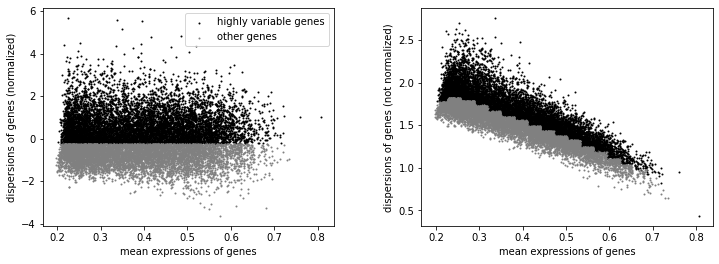

In [63]:
sc.pp.highly_variable_genes(atac, n_top_genes = 8000)
sc.pl.highly_variable_genes(atac)

In [74]:
np.sum(atac.var.highly_variable)

8000

In [65]:
atac.raw = atac

## LSI & PCA

In [66]:
ac.tl.lsi(atac,n_comps=20)

In [67]:
corr = np.zeros(20)
for i in range(20):
    corr[i]=np.corrcoef(atac.obs['ATAC_nCount_peaks'], atac.obsm['X_lsi'][:,i])[1,0]
corr    

array([ 0.79786044,  0.25841343,  0.17449529,  0.68513357, -0.14348673,
        0.04599986, -0.19892137, -0.16326814,  0.16313922,  0.02928009,
        0.03174468, -0.02373385, -0.00527089, -0.00687042, -0.00460984,
       -0.01738668,  0.01140409, -0.01029652, -0.00619072, -0.00230763])

In [68]:
atac.obsm['X_lsi_red'] = np.delete(atac.obsm['X_lsi'], obj=(0,3), axis = 1)
atac.varm["LSI"] = np.delete(atac.varm["LSI"], obj=(0,3), axis = 1)
atac.uns["lsi"]["stdev"] = np.delete(atac.uns["lsi"]["stdev"], obj=(0,3), axis =0)

/home/icb/nina.sander/miniconda3/envs/atac/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


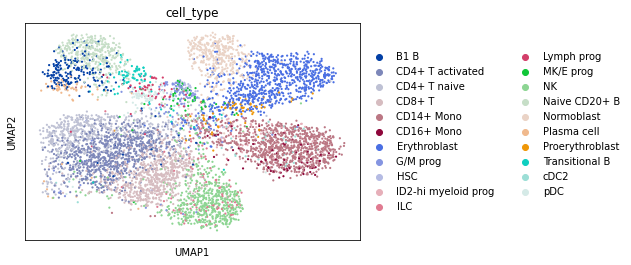

In [69]:
sc.pp.neighbors(atac, use_rep = 'X_lsi_red')
sc.tl.umap(atac)
sc.pl.umap(atac, color = 'cell_type')

/home/icb/nina.sander/miniconda3/envs/atac/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


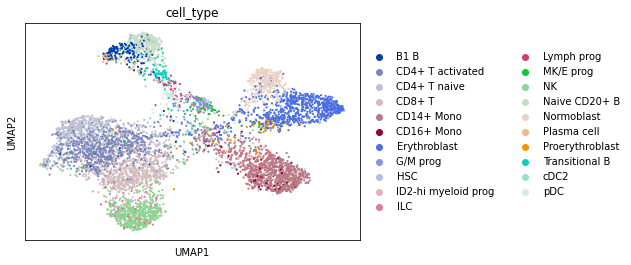

In [70]:
sc.tl.umap(atac,spread=1.2, min_dist=0.1)
sc.pl.umap(atac, color = 'cell_type')

/home/icb/nina.sander/miniconda3/envs/atac/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


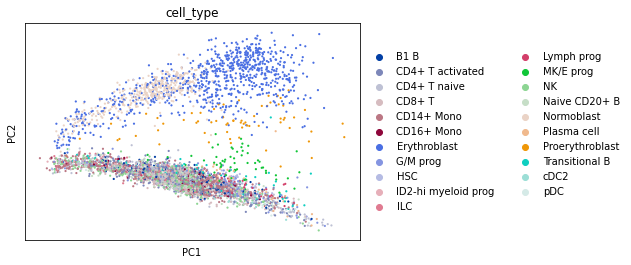

In [71]:
sc.pp.scale(atac)
sc.tl.pca(atac, svd_solver= 'arpack')
sc.pl.pca(atac, color='cell_type')

In [75]:
atac.write("atac-emb.h5ad")

In [80]:
atac.var['highly_variable']

chr1-629497-630394          True
chr1-633515-634474         False
chr1-778276-779191         False
chr1-827067-827948          True
chr1-869472-870377          True
                           ...  
GL000205.2-63003-63892      True
GL000195.1-30407-31261     False
GL000219.1-42172-43054     False
GL000219.1-99257-100160     True
KI270713.1-21434-22336     False
Name: highly_variable, Length: 14488, dtype: bool

In [81]:
atac[:,atac.var['highly_variable']]

View of AnnData object with n_obs × n_vars = 6224 × 8000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', '_scvi_batch', '_scvi_labels', 'cluster', 'n_counts'
    var: 'feature_types', 'gene_id', 'n_cells', 'chrom', 'chromStart', 'chromEnd', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'ATAC_gene_activity_var_names', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'dataset_id', 'genome', 'neighbors', 'organism', 'umap', 'log1p', 'hvg', 'lsi', 'pca'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_lsi_r